In [ ]:
!pip install numpy==1.26.4 --quiet > /dev/null 2>&1
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy
!pip install rdkit-pypi --quiet > /dev/null 2>&1

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

In [3]:
# SMILESをテンソルに変換する関数
def smiles_to_tensor(smiles_list, max_len):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    features = []
    for mol in mols:
        if mol is None:
            features.append([0] * max_len)  # パディング
        else:
            atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
            features.append(atom_features + [0] * (max_len - len(atom_features)))  # パディング
    return np.array(features, dtype=np.float32)

In [4]:
# データセットの作成
def create_dataset(smiles_list, max_len, batch_size):
    features = smiles_to_tensor(smiles_list, max_len)
    dataset = tf.data.Dataset.from_tensor_slices((features, features))
    dataset = dataset.shuffle(buffer_size=len(smiles_list))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [5]:
# モデルの定義
class Encoder(layers.Layer):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc2 = layers.Dense(hidden_dim, activation='relu')
        self.fc31 = layers.Dense(latent_dim)  # 平均
        self.fc32 = layers.Dense(latent_dim)  # 標準偏差の対数

    def call(self, x):
        h1 = self.fc1(x)
        h2 = self.fc2(h1)
        return self.fc31(h2), self.fc32(h2)

class Decoder(layers.Layer):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc2 = layers.Dense(hidden_dim, activation='relu')
        self.fc3 = layers.Dense(output_dim, activation='sigmoid')

    def call(self, z):
        h1 = self.fc1(z)
        h2 = self.fc2(h1)
        return self.fc3(h2)

class JT_VAE(models.Model):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(JT_VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(tf.shape(std))
        return mu + eps * std

    def call(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [6]:
# 損失関数の定義
def loss_function(recon_x, x, mu, logvar):
    bce_loss = MeanSquaredError()(x, recon_x)
    kld_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
    return bce_loss + kld_loss

In [7]:
# データの準備
smiles_data = [
    'CCO', 'CC(=O)OC1=CC=CC=C1C(=O)O', 'C1CCCCC1',
    'C1=CC=CC=C1', 'CCN(CC)CC', 'CC(C)CC',
    'C1=CC=C(C=C1)C=C', 'CC(=O)O', 'CC(=O)Nc1ccc(O)cc1', 'CC(C(=O)O)N'
]

In [8]:
# 最大長を設定（特徴ベクトルの長さを決定するため）
max_len = 20
batch_size = 2
dataset = create_dataset(smiles_data, max_len, batch_size)

In [9]:
# モデルの初期化
input_dim = max_len
hidden_dim = 64
latent_dim = 20
model = JT_VAE(input_dim, hidden_dim, latent_dim)
optimizer = Adam(learning_rate=1e-3)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        recon_batch, mu, logvar = model(x, training=True)
        loss = loss_function(recon_batch, x, mu, logvar)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
# トレーニングループ
num_epochs = 50  # エポック数
convergence_threshold = 1e-4
loss_list = []
prev_loss = float('inf')

log_frequency = 10  # ログを表示するエポックの間隔

for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in dataset:
        batch_loss = train_step(data)
        train_loss += batch_loss.numpy()

    avg_loss = train_loss / len(dataset)
    loss_list.append(avg_loss)

    # 指定されたエポック数ごとにログを表示
    if (epoch + 1) % log_frequency == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    # 収束の判定
    if abs(prev_loss - avg_loss) < convergence_threshold:
        print(f'Converged at epoch {epoch + 1}')
        break
    prev_loss = avg_loss

Epoch 10/50, Loss: 15.3198
Epoch 20/50, Loss: 12.1881
Epoch 30/50, Loss: 11.2235
Converged at epoch 39


In [11]:
# トレーニング損失をプロットする関数
def plot_training_loss(loss_list):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_list) + 1), loss_list)  # マーカーを削除
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

In [12]:
# SMILESの生成（プレースホルダー）
def generate_smiles(model, num_samples=10):
    z = tf.random.normal((num_samples, latent_dim))
    generated_features = model.decoder(z, training=False)
    # 実際には、生成された特徴量をSMILESに変換するモデルが必要です
    # ここではプレースホルダーとしてサンプルのSMILESを返します
    generated_smiles = ['CCO', 'C1=CC=CC=C1', 'CCN(CC)CC', 'CC(C)CC', 'C1=CC=C(C=C1)C=C',
                        'CC(=O)O', 'CC(=O)Nc1ccc(O)cc1', 'CC(C(=O)O)N', 'CCOCCO', 'CCOCCCC'][:num_samples]
    return generated_smiles

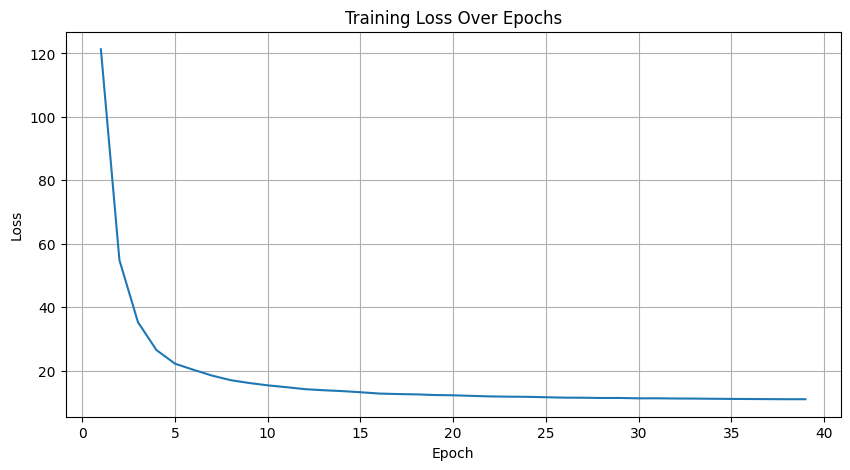

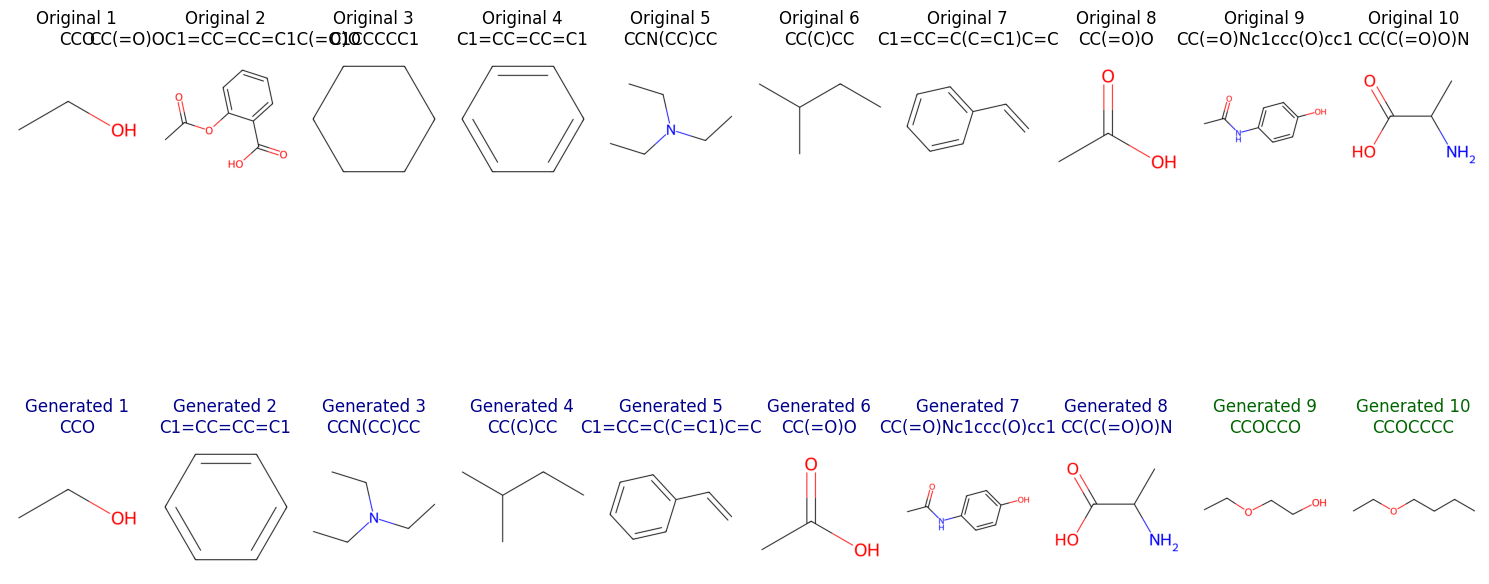

In [13]:
# SMILESの可視化
def visualize_comparison(original_smiles, generated_smiles):
    num_original = len(original_smiles)
    num_generated = len(generated_smiles)

    fig, axs = plt.subplots(2, max(num_original, num_generated), figsize=(15, 10))

    # 学習データに含まれているSMILESのセットを作成
    original_smiles_set = set(original_smiles)

    for i in range(max(num_original, num_generated)):
        if i < num_original:
            smiles = original_smiles[i]
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(300, 300))
            axs[0, i].imshow(img)
            axs[0, i].axis('off')
            axs[0, i].set_title(f'Original {i + 1}\n{smiles}')
        else:
            axs[0, i].axis('off')

        if i < num_generated:
            smiles = generated_smiles[i]
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=(300, 300))
            color = 'darkgreen' if smiles not in original_smiles_set else 'darkblue'
            axs[1, i].imshow(img)
            axs[1, i].axis('off')
            axs[1, i].set_title(f'Generated {i + 1}\n{smiles}', color=color)
        else:
            axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# トレーニングの実行
plot_training_loss(loss_list)

# SMILESの生成と可視化
generated_smiles = generate_smiles(model, num_samples=10)
visualize_comparison(smiles_data, generated_smiles)